# Analyse de données sous `Python`

Nous utilisons dans ce TP le module [`scikit-learn`](http://scikit-learn.org/), dédié au *Machine Learning*. Pour l'utiliser, nous importons les éléments un par un lorsqu'on en a besoin. Et nous allons aussi utiliser d'autres modules, que nous importons ici.

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white") # change le style par défaut des graphiques seaborn

%matplotlib inline

Pour appliquer les deux méthodes, nous allons réaliser une étude de cas, avec les données [`WGI`](https://fxjollois.github.io/donnees/WGI/wgi2019.csv). Celles-ci donnent certains indicateurs sur la gouvernance des pays (plus d'infos sur [cette page](http://info.worldbank.org/governance/wgi/#home)). Voici donc le code pour les importer dans un data frame `pandas`, et leur aperçu. Pour information, plus la valeur est haute, meilleur est le pays sur cet indicateur (et inversement).

In [2]:
# le dropna() permet de supprimer les pays pour lesquels il manque des informations
WGI_complet = pandas.read_csv("https://fxjollois.github.io/donnees/WGI/wgi2019.csv").dropna()
WGI_complet

,Country,Code,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law
0,Aruba,ABW,1.294189,1.357372,1.029933,0.857360,1.263128
1,Andorra,ADO,1.139154,1.615139,1.908749,1.228176,1.579939
2,Afghanistan,AFG,-0.988032,-2.649407,-1.463875,-1.120555,-1.713527
3,Angola,AGO,-0.777283,-0.311101,-1.117144,-0.893871,-1.054343
5,Albania,ALB,0.151805,0.118570,-0.061331,0.274380,-0.411179
...,...,...,...,...,...,...,...
209,Serbia,SRB,0.026626,-0.091665,0.019079,0.113867,-0.119070
210,South Africa,ZAF,0.670388,-0.217931,0.367380,0.156172,-0.076408
211,"Congo, Dem. Rep.",ZAR,-1.365966,-1.808007,-1.627429,-1.509667,-1.786088
212,Zambia,ZMB,-0.286199,-0.102216,-0.675215,-0.554269,-0.462069


## ACP

Dans le sous-module `decomposition`, nous allons importer la fonction [`PCA()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Le fonctionnement de celle-ci est similaire à toutes les autres dans `scikit-learn`. 

1. On créé d'abord un objet (nommé ici `pca`) qui va contenir le résultat de l'ACP. Dans la fonction `PCA()`, on pourra aussi indiquer les paramètres tels que le nombre de composants à retenir (`n_components` - ici on garde tout).
2. Ensuite, on ajuste (*fit*  en anglais) sur des données avec la fonction `fit()` de l'objet précédemment créé. Dans cette fonction, nous devons donc passer les données à utiliser (variables uniquement quantitatives).

Si l'on souhaite une ACP normée (ce qui n'est pas le cas ici), il nous faut standardiser les données en amont, avec par exemple la fonction `scale()` du sous-module `preprocessing` (importée aussi ici). Bien évidemment, il ne faut passer que des variables quantitatives, sans données manquantes.

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# suppression des colonnes non numériques
WGI_num = WGI_complet.drop(columns = ["Country", "Code"])
pca = PCA()
pca.fit(WGI_num)

PCA()

### Variance expliquée

L'objet `pca` comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (`explained_variance_` - proportionnelles aux valeurs propres) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (`explained_variance_ratio_`).

In [4]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[4.17153223 0.41073498 0.30677259 0.06485507 0.04785222]
[0.83401503 0.0821183  0.06133309 0.01296648 0.0095671 ]


Bien évidemment, il est possible (et préférable) de faire un tableau récapitulatif, avec les variances expliquées, les proportions de variance expliquée simples et cumulées. Voici un petit code permettant de faire ceci.

In [5]:
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(5)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,4.171532,83.0,83.0
1,Dim2,0.410735,8.0,92.0
2,Dim3,0.306773,6.0,98.0
3,Dim4,0.064855,1.0,99.0
4,Dim5,0.047852,1.0,100.0


L'idée est de représenter graphiquement ces proportions de variances expliquées (qu'on passe en pourcentage par convenance).

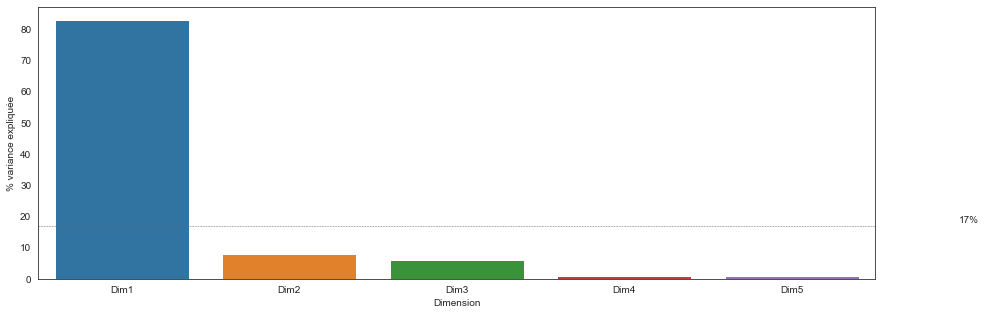

In [6]:
plt.figure(figsize = (15, 5)) # modifie la taille du graphique
seaborn.barplot(data = eig, x = "Dimension", y = "% variance expliquée")
plt.text(5, 18, "17%")
plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions)
plt.show() # cette ligne supprime l'affichage inutile en amont du graphique

On remarque ici qu'avec seulement deux dimensions suffisent à expliquer 91 %  de la variance des données. 

### Représentation des individus

Nous allons maintenant calculer les coordonnées des iris sur les dimensions, avec la fonction `transform()` de l'objet `pca`.

In [7]:
WGI_pca = pca.transform(WGI_num)

Afin de manipuler plus facilement l'objet obtenu par la suite, nous allons créer un `DataFrame` `pandas` en ne prenant que les deux premières dimensions, ainsi que les espèces.

In [8]:
# Transformation en DataFrame pandas
WGI_pca_df = pandas.DataFrame({
    "Dim1" : WGI_pca[:,0], 
    "Dim2" : WGI_pca[:,1],
    "Country" : WGI_complet["Country"]
})

# Résultat (premières lignes)
WGI_pca_df.head()

,Dim1,Dim2,Country
0,-2.638757,0.502308,Aruba
1,-3.410131,0.039344,Andorra
2,3.453682,-0.829503,Afghanistan
3,1.824034,0.440028,Angola
5,-0.077668,0.116001,Albania


Il est maintenant possible de représenter les données sur le premier plan factoriel. Dans ce graphique, il est important de noter le pourcentage de variance expliquée.

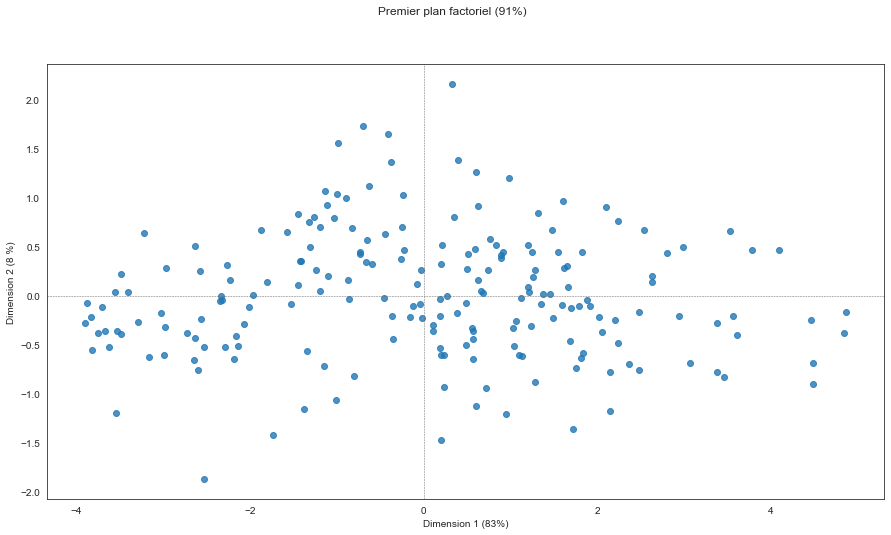

In [9]:
plt.figure(figsize = (15, 8))
plt.axvline(x = 0, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 0, linewidth = .5, color = "dimgray", linestyle = "--")
seaborn.regplot(data = WGI_pca_df, x = "Dim1", y = "Dim2", fit_reg = False)
plt.xlabel("Dimension 1 (83%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2 (8 %)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (91%)") # titre général
plt.show()

Dans ce même graphique, on veut repérer les individus aux extrêmes. Ci-dessous, nous affichons donc les noms des pays ayant des valeurs absolues élevées pour chaque composante.

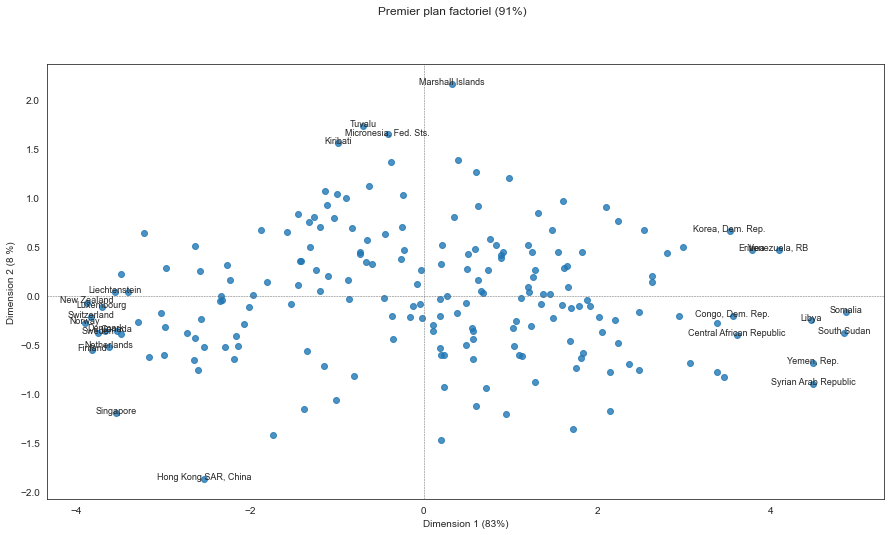

In [10]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(15,8))
plt.axvline(x = 0, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 0, linewidth = .5, color = "dimgray", linestyle = "--")

# l'option ax permet de placer les points et le texte sur le même graphique
seaborn.regplot(data = WGI_pca_df, x = "Dim1", y = "Dim2", fit_reg = False, ax = ax)

# boucle sur chaque pays
for k in WGI_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['Dim1']) > 3.5) | (abs(k[1]['Dim2']) > 1.5):
        ax.annotate(k[1]["Country"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9, ha = "center")
plt.xlabel("Dimension 1 (83%)") 
plt.ylabel("Dimension 2 (8 %)")
plt.suptitle("Premier plan factoriel (91%)")
plt.show()

### Représentation des variables

Lorsqu'on réalise une ACP, surtout dans un contexte exploratoire (et non de compression), il est absolument nécessaire de décrire les axesà partir des variables, afin de comprendre ce qu'ils représentent. Pour cela, nous devons réaliser le *cercle des corrélations*. Malheureusement, il faut le réaliser *à la main*.

In [11]:
n = WGI_num.shape[0] # nb individus
p = WGI_num.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = numpy.sqrt(eigval) # racine carrée des valeurs propres
corvar = numpy.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pandas.DataFrame({'id': WGI_num.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,Voice and Accountability,-0.853816,0.293912
1,Political Stability and Absence of Violence/Te...,-0.838199,0.412244
2,Government Effectiveness,-0.947230,-0.252506
3,Regulatory Quality,-0.939528,-0.282021
4,Rule of Law,-0.969197,-0.095275


Une fois ces coordonnées récupérées, on peut donc afficher ce cercle des corrélations comme ci-dessous.

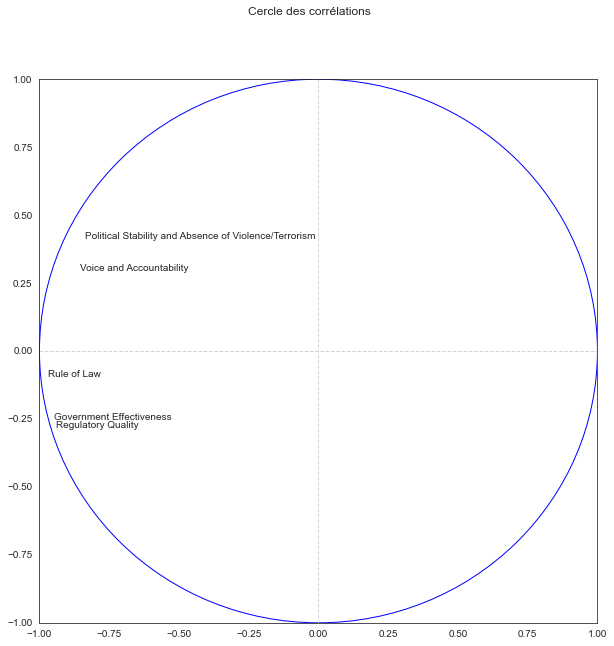

In [12]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (10, 10))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

Ici, on va en déduire que l'axe 1 oppose à gauche les pays avec une forte valeur dans tous les indicateurs (ils sont tous à gauche), et à droite les pays à faible valeur pour ces indicateurs.

L'axe 2 semble opposer les pays avec une valeur positive pour les indicateurs sur la statibilité politique et la prise en compte de l'avis des citoyens en haut, avec les pays avec une valeur négative pour ces 2 indicateurs en bas. 

Vous pouvez revenir sur le graphique des pays pour mieux comprendre.

## Classification

Nous allons ici réaliser une classification non supervisée. Bien évidemment, ici, nous pouvons peut-être supposé qu'une partition en 6 classes (1 par continent) est possible. Mais nous n'avons pas de réelle idée de ce nombre de classes. Pour l'estimer, nous allons utiliser 2 techniques.

### Classification Ascendante Hiérarchique (CAH)

La première possibilité est d'utiliser la CAH (avec le critère de Ward), afin d'obtenir un dendrogramme représentant les regroupements 2 à 2 de toutes les classes. 

Tout d'abord, nous importons la méthode, puis nous l'appliquons. Ici, on indique qu'on ne souhaite pas réaliser de *découpage* au préalable, et donc qu'on souhaite garder toute la hiérarchie.

In [13]:
from sklearn.cluster import AgglomerativeClustering

hac = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hac.fit(WGI_num)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Cette [page](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) décrit le programme permettant d'afficher le dendrogramme à partir du résultat de la fonction ci-dessous. Je recopie ici que la fonction (avec un peu d'adaptation).

In [14]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Nous utilisons donc cette méthode sur nos pays. On remarque un saut important entre 2 et 3 classes, puis entre 3 et 4 classes. On imagine donc qu'on pourrait couper la hiérarchie à ces 2 niveaux (cf graphique). Ainsi, cela suggère qu'on pourrait avoir une partition soit en 2 classes, soit en 3 classes.

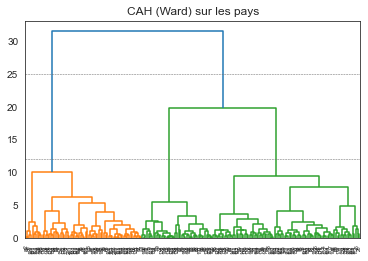

In [15]:
plt.title("CAH (Ward) sur les pays")
# plot the top three levels of the dendrogram
plot_dendrogram(hac)
plt.axhline(y = 25, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 12, linewidth = .5, color = "dimgray", linestyle = "--")
plt.show()

### $k$-means

L'autre méthode de classification classique est la méthode des $k$-means. Nous allons l'appliquer avec 2 et 3 classes afin de voir quelle partition serait la plus intéressante.

#### 2 classes

In [16]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters = 2)
kmeans2.fit(WGI_num)

KMeans(n_clusters=2)

On peut avoir ainsi les classes de chaque individus (qui nous servent ici à calculer la taille de chaque classe), ainsi que les centres des classes.

In [17]:
pandas.Series(kmeans2.labels_).value_counts()

0    113
1     89
dtype: int64

In [18]:
kmeans2.cluster_centers_

array([[-0.65390611, -0.69609133, -0.70131998, -0.67725302, -0.7361161 ],
       [ 0.80913972,  0.78274272,  0.82320404,  0.8019086 ,  0.86262377]])

Cette présentation n'est pas totalement satisfaisante, pour une lecture et analyse des résultats. Nous allons remédier à cela.

La première classe concerne les pays avec des valeurs positives sur tous les indicateurs, la seconde classe étant ceux avec des valeurs négatives.

In [19]:
WGI_k2 = WGI_num.assign(classe = kmeans2.labels_)
WGI_k2.groupby("classe").mean()

,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law
classe,,,,,
0,-0.653906,-0.696091,-0.701320,-0.677253,-0.736116
1,0.809140,0.782743,0.823204,0.801909,0.862624


En combinant ces informations avec l'ACP, on peut représenter ces 2 classes sur le plan factoriel. On voit bien la séparation horizontale des 2 classes.

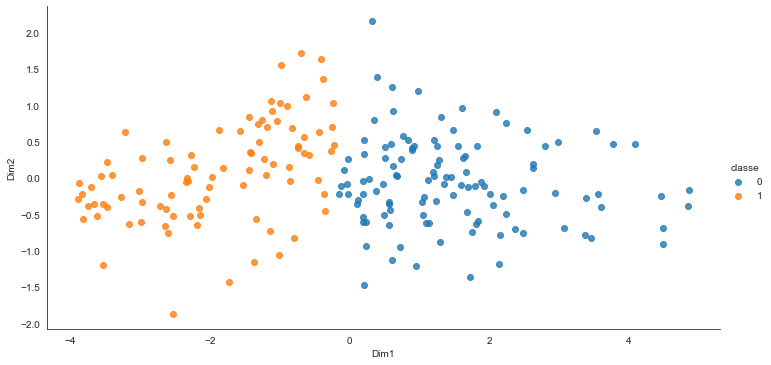

In [20]:
WGI_pca_k2 = WGI_pca_df.assign(classe = kmeans2.labels_)
seaborn.lmplot(data = WGI_pca_k2, x = "Dim1", y = "Dim2", hue = "classe", 
               fit_reg = False, height = 5, aspect = 2)
plt.show()

#### 3 classes

In [21]:
kmeans3 = KMeans(n_clusters = 3)
kmeans3.fit(WGI_num)

KMeans(n_clusters=3)

La plus grande classe semble être coupée en 2.

In [22]:
pandas.Series(kmeans3.labels_).value_counts()

2    87
0    68
1    47
dtype: int64

La classe 2 présente des valeurs très positives. La classe 0 semble être la classe des pays avec des valeurs proches de zéro. Et la classe 1, celle des pays avec des valeurs très faibles.

In [23]:
WGI_k3 = WGI_num.assign(classe = kmeans3.labels_)
WGI_k3.groupby("classe").mean()

,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law
classe,,,,,
0,-1.005108,-1.030116,-1.005825,-0.982840,-1.034689
1,1.060408,0.882350,1.359792,1.373400,1.363597
2,0.191151,0.225094,-0.017219,-0.033062,-0.001584


Sur la plan factoriel avec les 3 classes, on retrouve la séparation horizontale des classes, sans grande surprise.

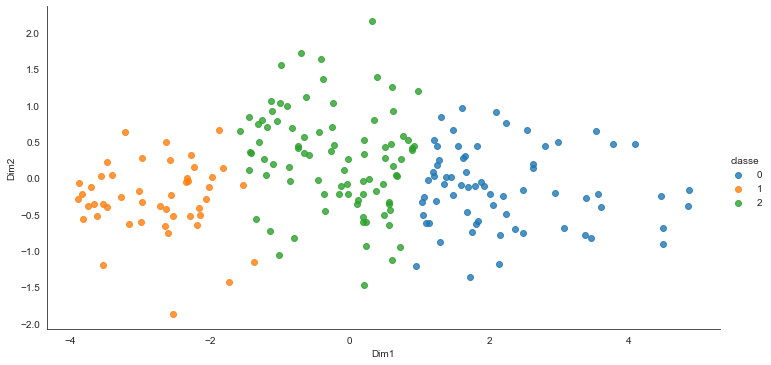

In [24]:
WGI_pca_k3 = WGI_pca_df.assign(classe = kmeans3.labels_)
seaborn.lmplot(data = WGI_pca_k3, x = "Dim1", y = "Dim2", hue = "classe", 
               fit_reg = False, height = 5, aspect = 2)
plt.show()

### Choix du nombre de classes avec $k$-means

L'algorithme $k$-means nous permet d'avoir à la fin l'inertie intra-classes, qui représente la disparité des individus à l'intérieur des classes. Plus cette valeur est proche de 0, meilleur est la partition. Malheureusement, la meilleure partition selon ce critère est donc celle avec autant de classes que d'individus (ce qui n'est pas très utile...).

On va donc chercher un point d'inflexion dans la courbe d'évolution de ce critère. Voici comment faire pour avoir ce graphique. Et ici, le point le plus marquant est celui à 2 classes. Ensuite, celui à 3 classes peut montrer aussi une certaine cassure dans l'évolution du critère.

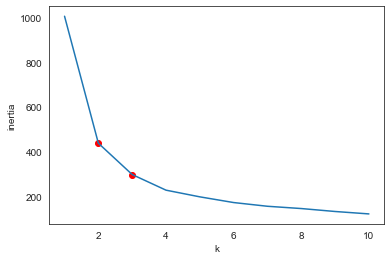

In [25]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(WGI_num)
    inertia = inertia + [kmeans.inertia_]
inertia = pandas.DataFrame({"k": range(1, 11), "inertia": inertia})
seaborn.lineplot(data = inertia, x = "k", y = "inertia")
plt.scatter(2, inertia.query('k == 2')["inertia"], c = "red")
plt.scatter(3, inertia.query('k == 3')["inertia"], c = "red")
plt.show()

## A faire

### Températures mondiales (anomalies)

Nous allons travailler ici sur les données de température mondiale HadCRUT4, fournies par [Climate Research Unit](https://crudata.uea.ac.uk/). Vous trouverez plus d’informations sur ces données sur ce [lien](https://crudata.uea.ac.uk/cru/data/temperature/). Nous avons ici plus exactement l'historique des anomalies moyennes mensuelles et annuelles depuis 1850, au niveau mondial, par rapport à la période de référence 1961-1990.

Le code ci-dessous télécharge directement les dernières données disponibles et les met dans un DataFrame dont vous avez un aperçu en dessous.

In [26]:
had = pandas.read_csv("https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat", header=None)
donnees = pandas.DataFrame(
    [list(map(lambda v: float(v), filter(lambda v: v!= "", h.split(" ")))) for h in had[0][::2]],
    columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Annual"]
)
donnees.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
167,2017.0,0.739,0.845,0.873,0.737,0.659,0.641,0.651,0.714,0.557,0.571,0.554,0.600,0.677
168,2018.0,0.554,0.528,0.615,0.627,0.587,0.573,0.594,0.586,0.598,0.678,0.590,0.638,0.597
169,2019.0,0.738,0.662,0.874,0.780,0.610,0.708,0.706,0.719,0.713,0.752,0.693,0.880,0.736
170,2020.0,0.982,1.001,1.017,0.800,0.714,0.682,0.695,0.735,0.714,0.617,0.761,0.516,0.768
171,2021.0,0.539,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.539


Vous devez donc réaliser les étapes suivantes, au propre dans un notebook :

- Décrire rapidement les données
    - Calculer les statistiques de base sur chaque mois et sur l'année
    - Réprésenter l'évolution des anomalies annuelles sur un graphique
- Réaliser une ACP sur les données mensuelles
- Produire les graphiques nécessaires à l’interprétation
- Identifier des années particulières
- Rechercher une partition intéressante des années
- Représenter cette partition sur le résultat de l'ACP
- Décrire les classes ainsi obtenues

Que peut-on dire globalement ?
